# Analyzing results of grid search

This notebook assumes you've downloaded data and run a grid search experiment
```sh
make update  # many hours
python mutrans.py --grid-search  # many hours
```

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 200

In [2]:
df = pd.read_csv("results/grid_search.tsv", sep="\t")
df = df.fillna("")
df

,model_type,cond_data,England B.1.1.7 MAE,England B.1.1.7 RMSE,England MAE,England RMSE,MAE,RMSE,loss,|μ|/σ max,...,ΔlogR(S:D614G) mean,ΔlogR(S:D614G) std,ΔlogR(S:E484K) mean,ΔlogR(S:E484K) std,ΔlogR(S:L452R) mean,ΔlogR(S:L452R) std,ΔlogR(S:N501Y) mean,ΔlogR(S:N501Y) std,ρ_lineage,ρ_mutation
0,reparam-asymmetric-biased,feature_scale=0.05,0.029536,0.145799,0.000461,0.007313,0.001177,0.017297,8.414005e+05,1188.942627,...,16.623970,0.017596,5.031677,0.038509,8.842990,0.061021,4.238866,0.014875,0.916227,0.774617
1,biased,feature_scale=0.1,0.034190,0.079971,0.000561,0.006835,0.001240,0.020751,2.381208e+07,97.969688,...,-162.420639,2.205356,0.162116,0.195372,0.037794,0.139510,0.153351,0.183460,0.816786,0.889804
2,reparam-locally-biased-overdispersed,feature_scale=0.1,0.030008,0.147602,0.000462,0.007155,0.001186,0.015182,5.892188e+06,507.556427,...,-0.030657,0.000392,0.390266,0.008340,1.209972,0.007806,0.800738,0.008164,0.605959,0.208037
3,locally-biased-dirichlet,,0.108584,0.187768,0.000961,0.009646,0.001233,0.020740,2.010005e+06,604.436401,...,-9.338909,0.015451,21.107346,0.346203,17.777494,0.671764,10.842891,0.593753,0.837859,0.538118
4,reparam-asymmetric-biased,feature_scale=0.2,0.029427,0.145820,0.000460,0.007132,0.001171,0.017171,8.602761e+05,932.609375,...,16.178247,0.018434,3.790396,0.043249,8.503430,0.056429,3.256316,0.012869,0.848438,0.415830
5,dirichlet,,0.157387,0.297380,0.000927,0.011810,0.001201,0.017007,8.180602e+05,85.667938,...,-0.853859,0.071798,3.382086,0.123606,5.294808,0.296789,2.720710,0.076721,0.714565,0.284673
6,biased-overdispersed,,0.053260,0.165468,0.000559,0.007772,0.000718,0.010952,2.329043e+07,348.283142,...,0.188642,0.000576,-0.352052,0.009870,0.117128,0.010651,0.179639,0.010554,0.706986,0.223415
7,reparam-biased-dirichlet,,0.100785,0.201827,0.000773,0.009132,0.001182,0.017935,7.252028e+05,397.879944,...,13.369585,0.043780,-0.196951,0.095468,2.008939,0.218592,-1.415783,0.095591,0.690065,0.255431
8,reparam-biased,,0.028774,0.144606,0.000460,0.006970,0.001177,0.018548,9.249198e+05,740.769592,...,12.957496,0.022829,-1.753517,0.028747,6.913398,0.043885,-0.888843,0.012961,0.617829,0.295944
9,locally-biased-overdispersed,,0.050360,0.163926,0.000538,0.007714,0.000704,0.010962,2.299595e+07,123.965172,...,-0.043958,0.000355,0.027421,0.012695,0.185416,0.021021,0.078785,0.019899,0.767099,0.141999


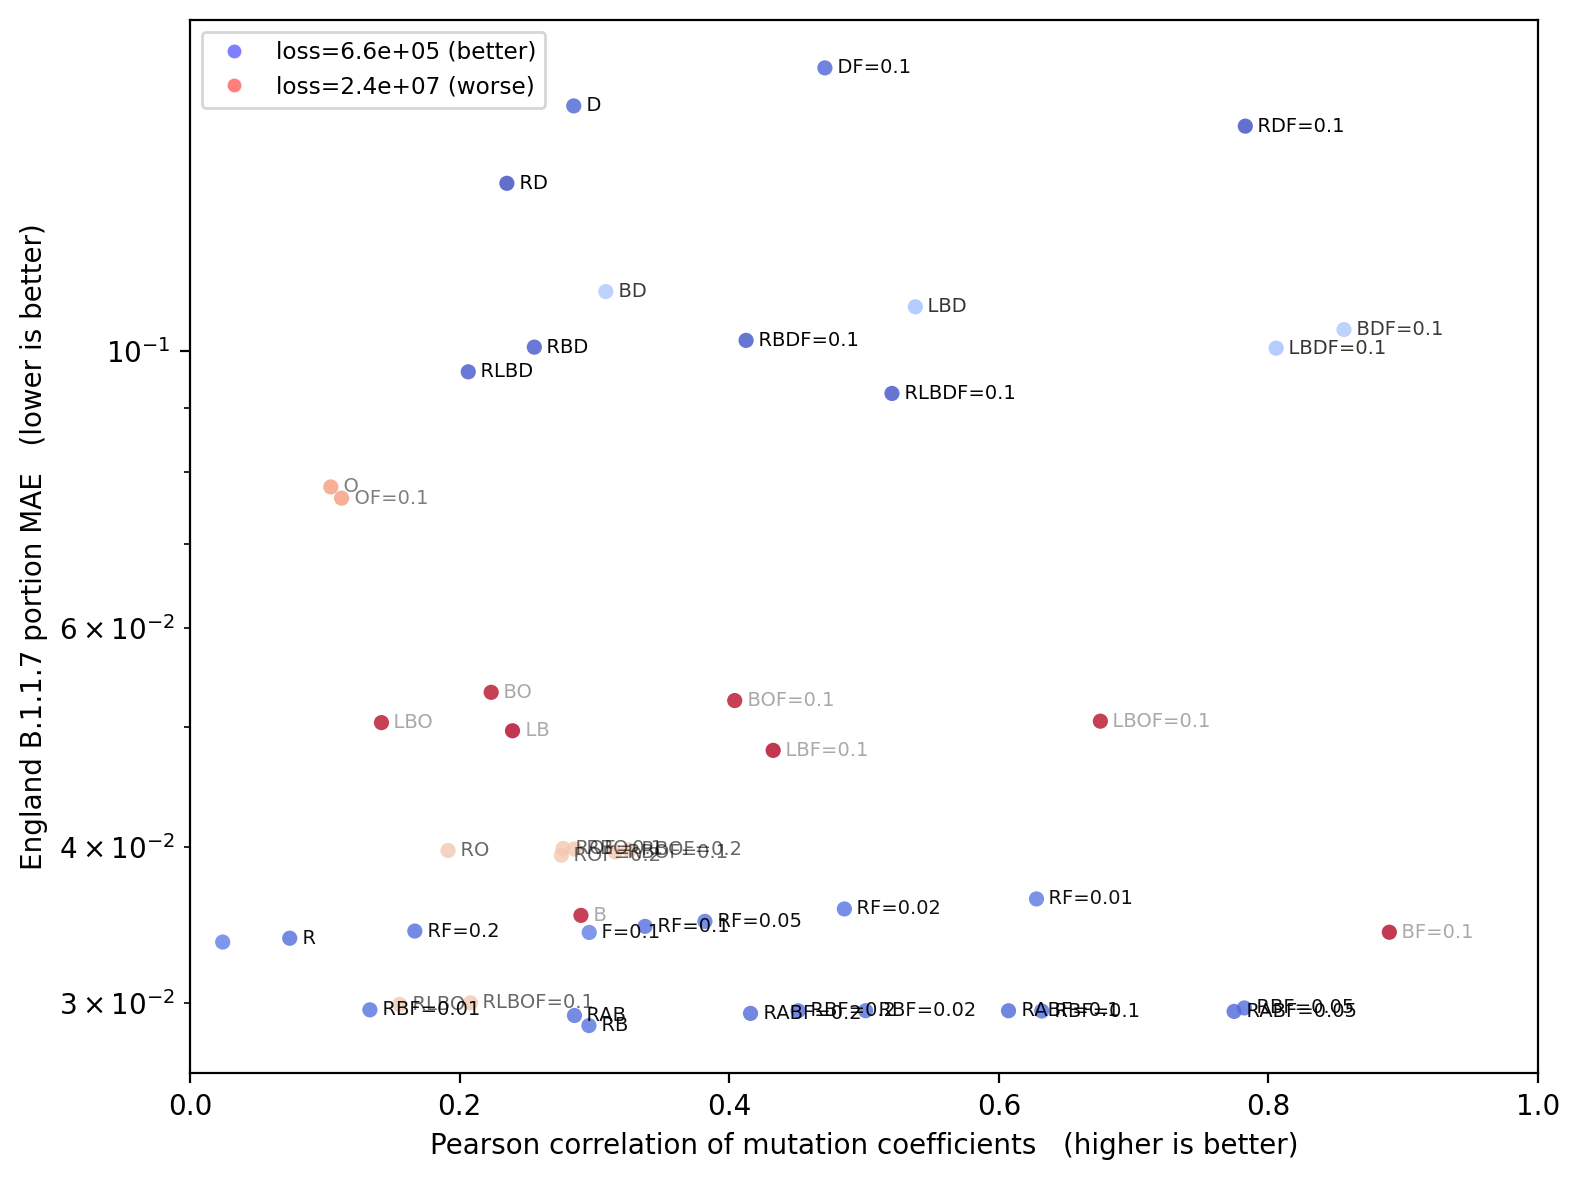

In [3]:
model_type = df["model_type"].to_list()
cond_data = df["cond_data"].to_list()
corr = df["ρ_mutation"].to_numpy()
mae = df["England B.1.1.7 MAE"].to_numpy()
loss = df["loss"].to_numpy()
min_loss, max_loss = loss.min(), loss.max()
assert (loss > 0).all(), "you'll need to switch to symlog or sth"
loss = np.log(loss)
loss -= loss.min()
loss /= loss.max()

def plot_corr_vs_mae(filenames=[]):
    plt.figure(figsize=(8, 6))
    plt.scatter(corr, mae, 30, loss, lw=0, alpha=0.8, cmap="coolwarm")
    plt.xlabel("Pearson correlation of mutation coefficients   (higher is better)")
    plt.ylabel("England B.1.1.7 portion MAE   (lower is better)")
    for x, y, mt, cd, l in zip(corr, mae, model_type, cond_data, loss):
        name = (
            f"  {mt}{cd}"
            .replace("feature_scale", "F")
            .replace("reparam", "R")
            .replace("asymmetric", "A")
            .replace("locally", "L")
            .replace("biased", "B")
            .replace("overdispersed", "O")
            .replace("dirichlet", "D")
            .replace("-", "")
        )
        plt.text(x, y, name, fontsize=7, va="center", alpha=1 - 0.666 * l)
    plt.plot([], [], "bo", markeredgewidth=0, markersize=5, alpha=0.5,
             label=f"loss={min_loss:0.2g} (better)")
    plt.plot([], [], "ro", markeredgewidth=0, markersize=5, alpha=0.5,
             label=f"loss={max_loss:0.2g} (worse)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xlim(0, 1)
    plt.yscale("log")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)
plot_corr_vs_mae(["paper/grid_search.png"])